In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#%cd /content/drive/My Drive/Ntu/nndl/CZ4042 Final Project

%cd /content/drive/My Drive/CZ4042 nndl/CZ4042 Final Project

#%cd /content/drive/My Drive/CZ4042 Final Project

Mounted at /content/drive
/content/drive/My Drive/CZ4042 nndl/CZ4042 Final Project


# Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import cv2
from PIL import Image

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Dropout, LayerNormalization
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [ ]:
!dir

AdienceBenchmarkGenderAndAgeClassification
adience_bn_after_activation_deep.ipynb
adience_bn_after_activation.ipynb
adience_corrected.ipynb
adience_original.ipynb
adience_original_no_norm.ipynb
adience_playground.ipynb
archive.zip
Augmentation.ipynb
augmentation\ test.ipynb
celeb\ a\ import\ pickle.ipynb
Celeb\ A.ipynb
Celeb\ A\ version\ 2.ipynb
data
Dataset
FMD
gender_history_bn_after_activation.pkl
gender_history_corrected.pkl
gender_history_deeper.pkl
gender_model_bn_after_activation.h5
gender_model_corrected.h5
gender_model_deeper.h5
gender_model.h5
gender_model_no_norm.h5
GoogLeNet.ipynb
Mask.ipynb
Notes.gdoc
Report.gdoc
test_Dataset
test_images_np.pkl
test.ipynb
train_images_np.pkl


In [ ]:
#load data

PATH = "/content/drive/.shortcut-targets-by-id/1c4oWg2n6LOBcg55d-i7mk7AHWJ0fN664/CZ4042 Final Project/AdienceBenchmarkGenderAndAgeClassification/"

data = pd.read_csv(PATH+"fold_0_data.txt",sep = "\t" )
data1 = pd.read_csv(PATH+"fold_1_data.txt",sep = "\t" )
data2 = pd.read_csv(PATH+"fold_2_data.txt",sep = "\t" )
data3 = pd.read_csv(PATH+"fold_3_data.txt",sep = "\t" )
data4 = pd.read_csv(PATH+"fold_4_data.txt",sep = "\t" )

data = pd.concat([data, data1, data2, data3, data4], ignore_index=True)

In [ ]:
data

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34
...,...,...,...,...,...,...,...,...,...,...,...,...
19365,7153718@N04,11598838386_349a0d4849_o.jpg,2282,None,NaN,596,460,1472,1473,-75,0,30
19366,7153718@N04,11598166203_c70bb34c80_o.jpg,2283,None,NaN,1179,755,331,331,5,0,108
19367,7153718@N04,11598166203_c70bb34c80_o.jpg,2282,None,NaN,1201,1179,293,293,5,0,99
19368,7153718@N04,11598145163_733cb99713_o.jpg,2282,None,NaN,1027,946,408,408,-85,0,49


In [ ]:
df = data[['age', 'gender', 'x', 'y', 'dx', 'dy']].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     19370 non-null  object
 1   gender  18591 non-null  object
 2   x       19370 non-null  int64 
 3   y       19370 non-null  int64 
 4   dx      19370 non-null  int64 
 5   dy      19370 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 908.1+ KB


In [ ]:
img_path = []
PATH = "/content/drive/.shortcut-targets-by-id/1c4oWg2n6LOBcg55d-i7mk7AHWJ0fN664/CZ4042 Final Project/AdienceBenchmarkGenderAndAgeClassification/faces/"

for row in data.iterrows():
    path = PATH+row[1].user_id+"/coarse_tilt_aligned_face."+str(row[1].face_id)+"."+row[1].original_image
    img_path.append(path)

df['img_path'] = img_path

In [ ]:
age_mapping = [('(0, 2)', '0-2'), ('2', '0-2'), ('3', '0-2'), ('(4, 6)', '4-6'), ('(8, 12)', '8-13'), ('13', '8-13'), 
               ('22', '15-20'), ('(8, 23)','15-20'), ('23', '25-32'), ('(15, 20)', '15-20'), ('(25, 32)', '25-32'), 
               ('(27, 32)', '25-32'), ('32', '25-32'), ('34', '25-32'), ('29', '25-32'), ('(38, 42)', '38-43'), 
               ('35', '38-43'), ('36', '38-43'), ('42', '48-53'), ('45', '38-43'), ('(38, 43)', '38-43'), 
               ('(38, 42)', '38-43'), ('(38, 48)', '48-53'), ('46', '48-53'), ('(48, 53)', '48-53'), ('55', '48-53'), 
               ('56', '48-53'), ('(60, 100)', '60+'), ('57', '60+'), ('58', '60+')]

age_mapping_dict = {each[0]: each[1] for each in age_mapping}
drop_labels = []
for idx, each in enumerate(df.age):
    if each == 'None':
        drop_labels.append(idx)
    else:
        df.age.loc[idx] = age_mapping_dict[each]

df = df.drop(labels=drop_labels, axis=0) #droped None values
df.age.value_counts(dropna=False)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


25-32    5296
38-43    2776
0-2      2509
8-13     2292
4-6      2140
15-20    1792
48-53     916
60+       901
Name: age, dtype: int64

In [ ]:
df = df.dropna()
unbiased_data = df[df.gender != 'u'].copy()
unbiased_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17452 entries, 0 to 19345
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       17452 non-null  object
 1   gender    17452 non-null  object
 2   x         17452 non-null  int64 
 3   y         17452 non-null  int64 
 4   dx        17452 non-null  int64 
 5   dy        17452 non-null  int64 
 6   img_path  17452 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.1+ MB


In [ ]:
gender_to_label_map = {
    'f' : 0,
    'm' : 1
}

age_to_label_map = {
    '0-2'  :0,
    '4-6'  :1,
    '8-13' :2,
    '15-20':3,
    '25-32':4,
    '38-43':5,
    '48-53':6,
    '60+'  :7
}

# label_to_age_map = {value: key for key, value in age_to_label_map.items()}
# label_to_gender_map = {value: key for key, value in gender_to_label_map.items()}

unbiased_data['age'] = unbiased_data['age'].apply(lambda age: age_to_label_map[age])
unbiased_data['gender'] = unbiased_data['gender'].apply(lambda g: gender_to_label_map[g])

unbiased_data.head()

,age,gender,x,y,dx,dy,img_path
0,4,0,0,414,1086,1383,/content/drive/.shortcut-targets-by-id/1c4oWg2...
1,4,1,301,105,640,641,/content/drive/.shortcut-targets-by-id/1c4oWg2...
2,4,0,2395,876,771,771,/content/drive/.shortcut-targets-by-id/1c4oWg2...
3,4,1,752,1255,484,485,/content/drive/.shortcut-targets-by-id/1c4oWg2...
4,4,1,175,80,769,768,/content/drive/.shortcut-targets-by-id/1c4oWg2...


In [ ]:
X = unbiased_data[['img_path']]
y = unbiased_data[['gender']]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from keras.utils import np_utils
y_train_one_hot = np_utils.to_categorical(y_train, num_classes=2)
y_test_one_hot = np_utils.to_categorical(y_test, num_classes=2)

print('Train data shape {}'.format(X_train.shape))
print('Test data shape {}'.format(X_test.shape))

Train data shape (12216, 1)
Test data shape (5236, 1)


In [ ]:
# train_images = []
# test_images = []

# for row in X_train.iterrows():
#     image = Image.open(row[1].img_path)
#     image = image.resize((227, 227))   # Resize the image
#     data = np.asarray(image)
#     train_images.append(data)

# for row in X_test.iterrows():
#     image = Image.open(row[1].img_path)
#     image = image.resize((227, 227))  # Resize the image
#     data = np.asarray(image)
#     test_images.append(data)

# train_images = np.asarray(train_images)
# test_images = np.asarray(test_images)

# print('Train images shape {}'.format(train_images.shape))
# print('Test images shape {}'.format(test_images.shape))

# save numpy array

In [ ]:
# import pickle

# with open('train_images_np.pkl','wb') as f:
#     pickle.dump(train_images, f)

# with open('test_images_np.pkl','wb') as f:
#     pickle.dump(test_images, f)


# load numpy array

In [ ]:
import pickle

with open('train_images_np.pkl','rb') as f:
     train_images = pickle.load(f)

with open('test_images_np.pkl','rb') as f:
     test_images = pickle.load(f)

print(train_images.shape)
print(test_images.shape)

(12216, 227, 227, 3)
(5236, 227, 227, 3)


### Create model architecture

In [ ]:
model = Sequential([
      layers.Conv2D(96, (7, 7), padding='valid',activation = 'relu', input_shape=(227, 227, 3)),
      layers.BatchNormalization(),
      layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),
      
      layers.Conv2D(256, (5, 5), padding='valid', activation='relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),
      
      layers.Conv2D(384, (3, 3), padding='valid', activation='relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),

      # added more layers from original PA
      layers.Conv2D(384, (3, 3), padding='valid', activation='relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),
      layers.Conv2D(384, (3, 3), padding='valid', activation='relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),
      #------------------

      layers.Flatten(),
      layers.Dense(512, activation='relu'),
      layers.Dropout(0.25),
      layers.Dense(512, activation='relu'),
      layers.Dropout(0.25),
      layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 221, 221, 96)      14208     
                                                                 
 batch_normalization (BatchN  (None, 221, 221, 96)     384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 96)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 256)     614656    
                                                                 
 batch_normalization_1 (Batc  (None, 106, 106, 256)    1024      
 hNormalization)                                                 
                                                        

In [ ]:
epochs=15

history = model.fit(train_images, y_train_one_hot, validation_data=(test_images, y_test_one_hot), epochs=epochs, batch_size=32, verbose=2)

Epoch 1/15
382/382 - 315s - loss: 0.8865 - accuracy: 0.5788 - val_loss: 0.6330 - val_accuracy: 0.6610 - 315s/epoch - 824ms/step
Epoch 2/15
382/382 - 253s - loss: 0.6048 - accuracy: 0.6773 - val_loss: 0.6969 - val_accuracy: 0.6249 - 253s/epoch - 662ms/step
Epoch 3/15
382/382 - 254s - loss: 0.5087 - accuracy: 0.7490 - val_loss: 0.4778 - val_accuracy: 0.7638 - 254s/epoch - 665ms/step
Epoch 4/15
382/382 - 253s - loss: 0.4243 - accuracy: 0.8006 - val_loss: 0.4187 - val_accuracy: 0.8061 - 253s/epoch - 662ms/step
Epoch 5/15
382/382 - 252s - loss: 0.3717 - accuracy: 0.8267 - val_loss: 0.4283 - val_accuracy: 0.8052 - 252s/epoch - 660ms/step
Epoch 6/15
382/382 - 251s - loss: 0.3284 - accuracy: 0.8536 - val_loss: 0.4031 - val_accuracy: 0.8165 - 251s/epoch - 656ms/step
Epoch 7/15
382/382 - 251s - loss: 0.2934 - accuracy: 0.8734 - val_loss: 0.4723 - val_accuracy: 0.7414 - 251s/epoch - 657ms/step
Epoch 8/15
382/382 - 251s - loss: 0.2661 - accuracy: 0.8880 - val_loss: 0.3829 - val_accuracy: 0.8291 - 

In [ ]:
# model.save('gender_model_bn_after_activation_deep.h5')

In [ ]:
%cd /content/drive/My Drive/CZ4042 Final Project

/content/drive/.shortcut-targets-by-id/1c4oWg2n6LOBcg55d-i7mk7AHWJ0fN664/CZ4042 Final Project


In [ ]:
with open('gender_history_bn_after_activation_deep.pkl','wb') as f:
    pickle.dump(history.history, f)

# Load and try model

In [ ]:
from tensorflow import keras

import tensorflow as tf
import PIL
import PIL.Image
import numpy as np
import pickle

from google.colab import drive
from keras.utils import np_utils

#%cd /content/drive/My Drive/CZ4042 Final Project
gender_model = keras.models.load_model('/content/drive/My Drive/CZ4042 nndl/CZ4042 Final Project/gender_model_bn_after_activation_deep.h5')

#gender_model = keras.models.load_model('/content/drive/My Drive/CZ4042 Final Project/gender_model_bn_after_activation_deep.h5')

In [ ]:
def numpy_to_tensor(numpy_input):
    tensor = tf.convert_to_tensor(numpy_input, dtype=tf.float32)
    return tf.expand_dims(tensor, axis=0)

def truth_output(softmax_output):
  if softmax_output[0] > softmax_output[1]:
      return "Female"
  else:
      return "Male"

def predicted_output(softmax_output):
  if softmax_output[0][0] > softmax_output[0][1]:
      return "Female"
  else:
      return "Male"

def try_model(index):
    display(PIL.Image.fromarray(np.uint8(train_images[index])))

    print(f"truth value: {truth_output(y_train_one_hot[index])}")
    print(f"predicted value: {predicted_output(gender_model.predict(numpy_to_tensor(train_images[index])))}")

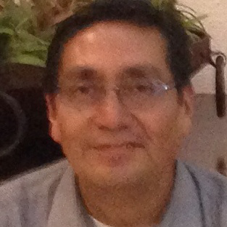

truth value: Male
predicted value: Male


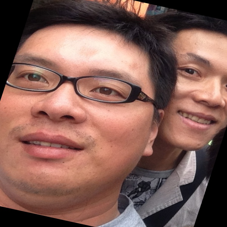

truth value: Male
predicted value: Male


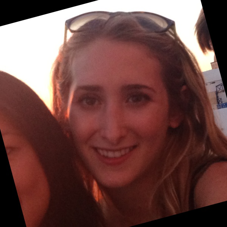

truth value: Female
predicted value: Female


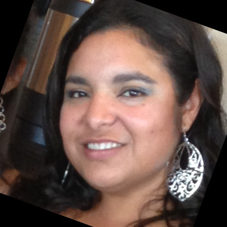

truth value: Female
predicted value: Female


In [ ]:
try_model(1002)
try_model(1003)
try_model(1004)
try_model(10)

# Performance evaluation

## Accuracy against epoch

In [ ]:
with open('gender_history_bn_after_activation_deep.pkl','rb') as f:
     history_list = pickle.load(f)

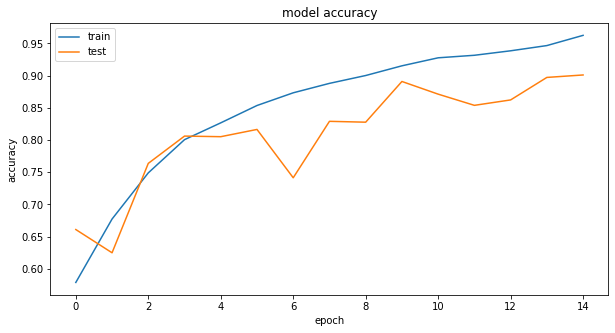

In [ ]:
# Plot accuracies of training and test data
plt.figure(figsize=(10,5))
plt.plot(history_list['accuracy'])
plt.plot(history_list['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show();

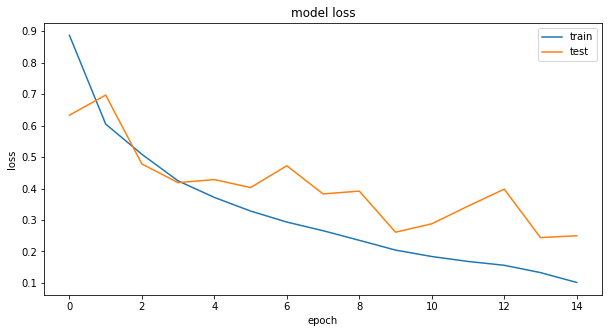

In [ ]:
# Plot losses of training and test data
plt.figure(figsize=(10,5))
plt.plot(history_list['loss'])
plt.plot(history_list['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show();

In [ ]:
y_pred = gender_model.predict(test_images)
proba = y_pred.max(axis=1).reshape(-1, 1)
y_proba_positive = y_pred[:,1:]
y_pred_one_hot = np.where(y_pred == proba, 1, 0)
y_pred_int = [np.where(r==1)[0][0] for r in y_pred_one_hot]

y_true = [np.where(r==1)[0][0] for r in y_test_one_hot]

## F1, Precision, Recall

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score

In [ ]:
accuracy = accuracy_score(y_true, y_pred_int)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_true, y_pred_int)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true, y_pred_int)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true, y_pred_int)
print('F1 score: %f' % f1)

# ROC AUC
auc = roc_auc_score(y_true, y_proba_positive.flatten())
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_true, y_pred_int)
print(matrix)

Accuracy: 0.901070
Precision: 0.904508
Recall: 0.885634
F1 score: 0.894972
ROC AUC: 0.966065
[[2511  233]
 [ 285 2207]]


# Confusion Matrix - Train

In [ ]:
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred_int,num_classes=2).numpy()
con_mat

array([[2511,  233],
       [ 285, 2207]], dtype=int32)

In [ ]:
classes=['male','female']

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

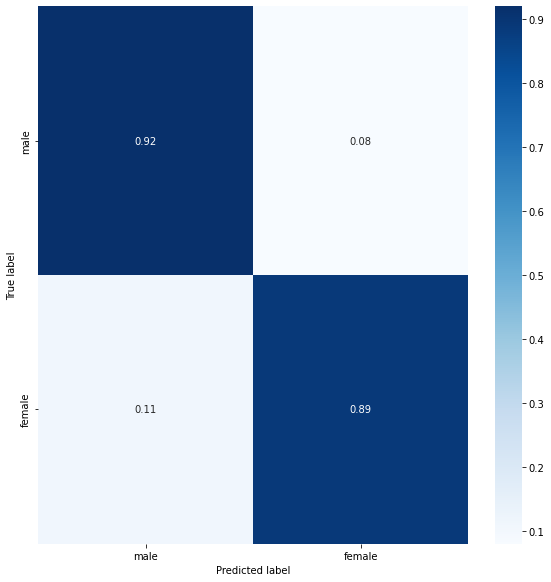

In [ ]:
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues,)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# ROC Curve

In [ ]:
from sklearn.metrics import roc_curve,roc_auc_score
fpr , tpr , thresholds = roc_curve (y_true , y_proba_positive.flatten())

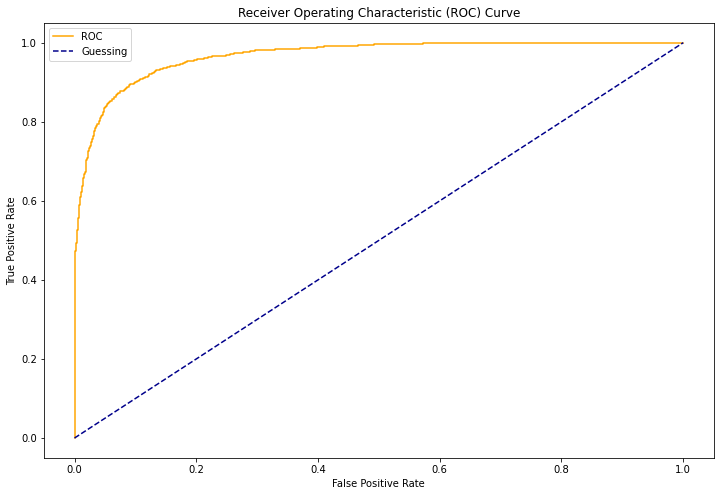

In [ ]:
def plot_roc_curve(fpr, tpr):
    """
    Plots a ROC curve given the false positve rate (fpr) and 
    true postive rate (tpr) of a classifier.
    """
    # Plot ROC curve
    figure = plt.figure(figsize=(12, 8))
    plt.plot(fpr, tpr, color='orange', label='ROC')
    # Plot line with no predictive power (baseline)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Guessing')
    # Customize the plot
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

plot_roc_curve(fpr, tpr)